# Single-Shot Readout Calibration for UA Q2

### Using Experiment and Analysis Class, make sure to update qubit #

In [1]:
from qm.qua import *
from qm import QuantumMachinesManager, SimulationConfig, LoopbackInterface, generate_qua_script
from qm.octave import *
from qm.octave.octave_manager import ClockMode
from configuration import *
from scipy import signal
from qualang_tools.bakery import baking
from qualang_tools.units import unit
from qm.octave import QmOctaveConfig
from set_octave import ElementsSettings, octave_settings
from quam import QuAM
from scipy.io import savemat, loadmat
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from qutip import *
from typing import Union
from macros import *
import datetime 
import os
import time
import warnings
import json
import matplotlib.pyplot as plt
import numpy as np
import Labber

from ExperimentClass import ExperimentHandle
from AnalysisClass import AnalysisHandle

warnings.filterwarnings("ignore")

qubit_index = 1 # for UA Q2
res_index = 1 # for UA Q2
flux_index = 1 # for UA Q2
TLS_index = 0 # for TLS of interest

2024-05-08 10:33:10,193 - qm - INFO     - Starting session: 396e20e0-ee55-4ee4-ae94-ff0aaf731db7


In [2]:
Experiment = ExperimentHandle()
Analysis = AnalysisHandle()
machine = Analysis.get_machine()

In [3]:
# initialize Labber-controlled hardware
Experiment.set_Labber(Analysis.get_machine(), qubit_index, res_index, flux_index)
# set to sweet spot
machine = Experiment.set_QDAC(qubit_index,res_index,flux_index,machine.flux_lines[flux_index].max_frequency_point)
# set octave to external clock
#Experiment.set_external_clock()

In [158]:
# Set the qubit freq, in case I was working with something else
machine.qubits[qubit_index].f_01 = machine.qubits[qubit_index].f_tls[0] + 0E6
machine.qubits[qubit_index].lo = machine.qubits[qubit_index].f_01 + 50E6
machine = Analysis.set_machine(machine)

In [159]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-05-08 09:58:49,922 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-05-08 09:58:49,934 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
2024-05-08 09:58:57,710 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.248 GHz, -50.000 MHz)
2024-05-08 09:59:12,063 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


## 1D resonator spectroscopy

In [6]:
%matplotlib qt
machine = Analysis.get_machine()
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-5E6,5E6 + 1.0,0.05E6)
machine, res_freq_sweep, sig_amp = Experiment.exp1D.RR.rr_freq(res_freq_sweep, qubit_index, res_index, flux_index, 
                           n_avg = 1E3, cd_time = 5E3, readout_state = 'g', simulate_flag = False, simulation_len = 1000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 0.97s


resonator frequency: 7134.000 MHz
Execution stopped by user!


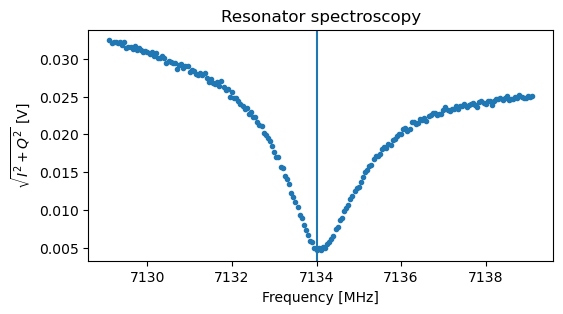

In [7]:
# find the minimal
%matplotlib inline
res_freq = Analysis.exp1D.rr_freq(res_freq_sweep, sig_amp)
if True:
    machine.resonators[res_index].f_readout = res_freq.tolist() + 0E6
    machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
    machine = Analysis.set_machine(machine)

## 1D qubit spectroscopy

In [29]:
# for the DC flux
#qubit_freq_est = np.polyval(machine.qubits[qubit_index].DC_tuning_curve,machine.flux_lines[flux_index].max_frequency_point) * 1E6 # in Hz
# for the fast flux
qubit_freq_sweep = machine.qubits[qubit_index].f_01 + np.arange(-30E6, 30E6 + 1, 0.5E6)
    
%matplotlib qt
machine, qubit_freq_sweep, sig_amp = Experiment.exp1D.Rabi.qubit_freq(qubit_freq_sweep, qubit_index, res_index, flux_index, 
                                      pi_amp_rel = 1.0, ff_amp = 0.0, n_avg = 1E3, cd_time = 20E3, plot_flag = True, 
                                      simulate_flag = False, simulation_len = 4000)

Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.18s
Progress: [##################################################] 100.0% (n=1000/1000.0) --> elapsed time: 2.28s


resonant frequency: 6198.105 MHz


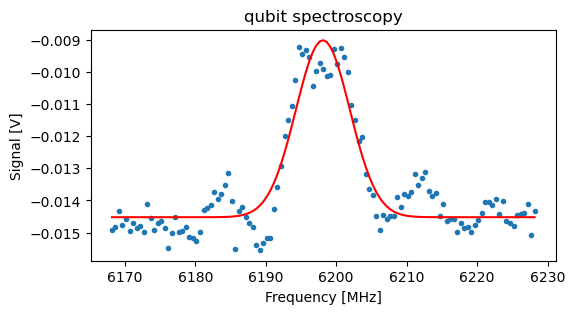

In [31]:
%matplotlib inline
qubit_freq = Analysis.exp1D.peak_fit(x=qubit_freq_sweep,y=-sig_amp,method="gaussian")
qubit_freq = int(qubit_freq.tolist())
machine.qubits[qubit_index].f_01 = qubit_freq + 0E6
machine.qubits[qubit_index].f_tls[0] = qubit_freq + 0E6
machine.qubits[qubit_index].lo = qubit_freq + 50E6
machine = Analysis.set_machine(machine)

## Measure single-shot I, Q blobs

In [6]:
%matplotlib inline
machine, Ig, Qg, Ie, Qe = Experiment.exp1D.RR.single_shot_IQ_blob(machine.resonators[res_index].f_readout, qubit_index, res_index, flux_index,
                              n_avg = 120E3, cd_time = 20E3, plot_flag = False)


			Fidelity Matrix:
			-----------------
			| 0.960 | 0.040 |
			----------------
			| 0.162 | 0.838 |
			-----------------
			IQ plane rotated by: 359.9°
			Threshold: -1.189e-03
			Fidelity: 89.9%
			


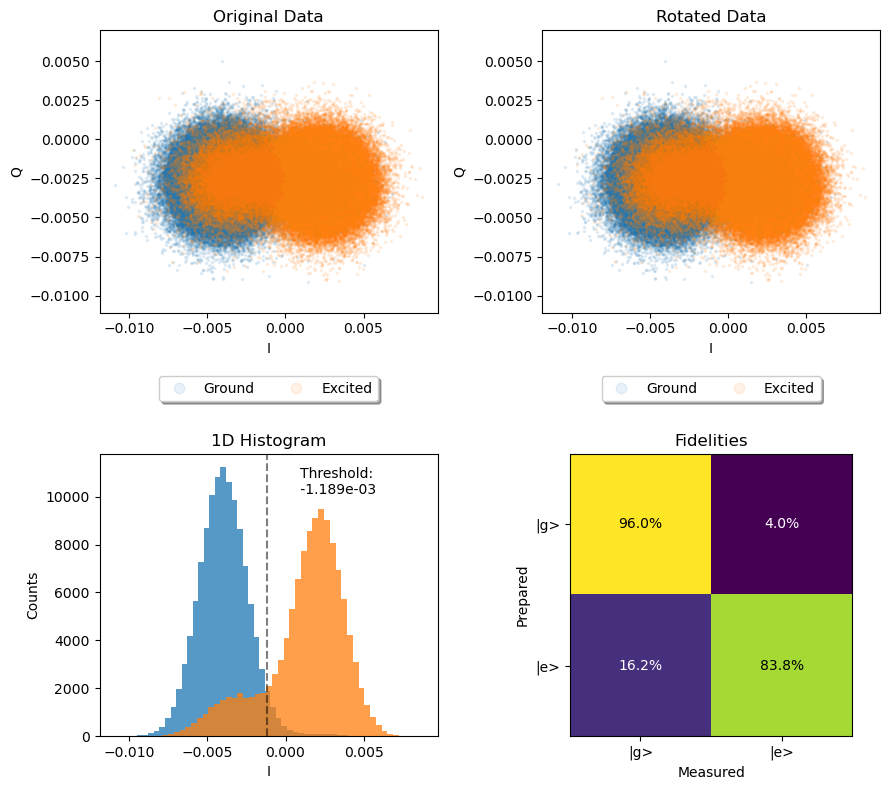

In [7]:
%matplotlib inline
angle, threshold, fidelity, gg, ge, eg, ee = Analysis.exp1D.two_state_discriminator(Ig, Qg, Ie, Qe, plot_flag=True)

In [5]:
# set the rotation angle
machine.resonators[res_index].rotation_angle -= angle.item()
machine.resonators[res_index].ge_threshold = threshold.item()
machine = Analysis.set_machine(machine)

## optimize readout duration and amp

In [32]:
%matplotlib qt
res_duration_sweep_abs = np.arange(300, 2000 + 1, 20)
res_amp_sweep = np.arange(0.05,0.5,0.002)
machine, res_amp_sweep, res_duration_sweep_abs, sig_amp = Experiment.exp2D.RR.rr_pulse_optimize(res_duration_sweep_abs, res_amp_sweep, qubit_index, res_index, flux_index, 
                    n_avg=10E3, cd_time=20E3, simulate_flag=False, simulation_len=1000, plot_flag=True, machine=machine)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 4249.88s


In [146]:
machine.resonators[res_index].readout_pulse_amp = 0.5
machine.resonators[res_index].readout_pulse_length = 1096
machine = Analysis.set_machine(machine)

## optimize single-shot frequency

In [17]:
res_freq_sweep = machine.resonators[res_index].f_readout + np.arange(-3E6, 2E6 + 1, 0.02E6)

%matplotlib qt
machine, SNR, res_freq_opt = Experiment.exp1D.RR.single_shot_freq_optimization(res_freq_sweep, qubit_index, res_index, flux_index,
                              n_avg = 10E3, cd_time = 25E3, plot_flag = True)

Progress: [##################################################] 100.0% (n=10000/10000.0) --> elapsed time: 130.10s
The optimal readout frequency is 7133060104.0 Hz (SNR=2.9252762466570306)


In [18]:
machine.resonators[res_index].f_readout = res_freq_opt.tolist() + 0E6
machine.resonators[res_index].lo = machine.resonators[res_index].f_readout + 50E6
machine = Analysis.set_machine(machine)

In [19]:
# octave calibration
Experiment.octave_calibration(qubit_index,res_index,flux_index,calibration_flag = True)

2024-05-01 12:05:21,422 - qm - INFO     - Performing health check


INFO:qm.api.frontend_api:Performing health check


2024-05-01 12:05:21,433 - qm - INFO     - Health check passed


INFO:qm.api.frontend_api:Health check passed


------------------------------------- Calibrates r1 for (LO, IF) = (7.183 GHz, -50.000 MHz)
2024-05-01 12:05:29,337 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


------------------------------------- Calibrates q1 for (LO, IF) = (6.248 GHz, -50.000 MHz)
2024-05-01 12:05:43,759 - qm - INFO     - Compiling program


INFO:qm.QuantumMachine:Compiling program


# These are from QM, and I don't think they work very well...

## optimize single-shot amplitude

In [54]:
res_amp_sweep = np.arange(0.5,1.5 + 1E-4, 0.01)

%matplotlib qt
machine, res_amp_sweep_abs, fidelity, res_amp_opt = Experiment.exp1D.RR.single_shot_amp_optimization(res_amp_sweep, qubit_index, res_index, flux_index,
                              n_avg = 40E3, cd_time = 25E3, plot_flag = True)

some abs amps > 0.5, removed from experiment run
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.35s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.38s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.40s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.43s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.45s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.48s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.51s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.53s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 119.5

Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.37s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.42s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.43s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.45s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.46s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.47s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.49s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.50s
Progress: [##################################################] 100.0% (n=59/59) --> elapsed time: 121.51s
Progress: [###################################

In [51]:
machine.resonators[res_index].readout_pulse_amp = 0.288
machine = Analysis.set_machine(machine)

## optimize single-shot readout duration

In [112]:
readout_len = 4E3
ringdown_len = 1E3
division_length = 10

%matplotlib qt
machine, res_duration_sweep, SNR, opt_readout_length = Experiment.exp1D.RR.single_shot_duration_optimization(readout_len, ringdown_len, division_length, 
                            qubit_index, res_index, flux_index, n_avg = 20E3, cd_time = 25E3, plot_flag = True)

Integration weights chunk-size length in clock cycles: 10
The readout has been sliced in the following number of divisions 125
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 10.58s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 11.02s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 11.43s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 11.84s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 12.26s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 12.66s
Progress: [##################################################] 100.0% (n=20000/20000.0) --> elapsed time: 13.06s
Progress: [##################################################] 100.0% (n=20000/200

In [43]:
machine.resonators[res_index].readout_pulse_length = 1000
machine = Analysis.set_machine(machine)